In [1]:
import sys
import os
import math
import operator

sys.path.insert(0, os.path.abspath('..'))

# from autocnet import cuda
from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.cpu_matcher import FlannMatcher
from autocnet.utils.utils import normalize_vector
from autocnet.matcher.deepen_funcs import dist_to_epipolar
from autocnet.camera.camera import compute_epipolar_line
from autocnet.control.control import ControlNetwork
import shapely.wkt as swkt
import geopandas as gpd
from scipy.spatial import KDTree

import networkx as nx
import pandas as pd
import random
from IPython.display import display

%pylab inline
figsize(20, 20)

Populating the interactive namespace from numpy and matplotlib


/scratch/anaconda3/envs/autocnet/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#Point to the adjacency Graph
adjacency = get_path('cube_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(extractor_method='sift', extractor_parameters={'nfeatures':500})

#Match
cg.match()

#Apply outlier detection
cg.apply_func_to_edges(Edge.symmetry_check)
cg.apply_func_to_edges(Edge.ratio_check)
cg.compute_fundamental_matrices(clean_keys=['symmetry', 'ratio'])

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
cg.create_control_network(clean_keys = ['fundamental'])

In [5]:
def get_x(y, m, b):
    return (m/y) - b

def get_y(x, m, b):
    return (m*x) + b

In [6]:
def find_match(keypoint, keypoints, edge, source, destination, func, *args, **kwargs):
    return func(keypoint, keypoints, edge, source, destination, *args, **kwargs)

r = lambda: random.uniform(0.0, 1.0)
color = [r(), r(), r()]

def source_to_dest(kp, source, destination, homogeneous = False):
    source_latlon = source.geodata.pixel_to_latlon(kp[0], kp[1])
    if homogeneous:
        return destination.geodata.latlon_to_pixel(source_latlon[0], source_latlon[1]) + (1,)
    else:
        return destination.geodata.latlon_to_pixel(source_latlon[0], source_latlon[1])
    
def dest_to_source(kp, source, destination, homogeneous = False):
    dest_latlon = destination.geodata.pixel_to_latlon(kp[0], kp[1])
    if homogeneous:
        return source.geodata.latlon_to_pixel(dest_latlon[0], dest_latlon[1]) + (1,)
    else:
        return source.geodata.latlon_to_pixel(dest_latlon[0], dest_latlon[1])

In [200]:
# needs reprojected point into keypoints space, and the keypoints for that space
def nearest_neighbor(keypoint, keypoints, edge, source, destination, num_neighbors = 5):
    if source < destination:
        reproj_keypoint = source_to_dest(keypoint, edge.source, edge.destination, homogeneous=True)
    else:
        reproj_keypoint = dest_to_source(keypoint, edge.source, edge.destination, homogeneous=True)
    kd_tree = KDTree(data = keypoints)
    return kd_tree.query(reproj_keypoint, num_neighbors, eps = 2, p = 1)[1]

def dist_to_epipolar(keypoint, keypoints, edge, source, destination, geometric_threshold=1):
    if source < destination:
        f_matrix = edge['fundamental_matrix'].T
    else:
        f_matrix = edge['fundamental_matrix']
    epipolar_line = compute_epipolar_line(keypoint, f_matrix) 
    bc_distance = np.abs(epipolar_line.dot(keypoints.T))
    return np.where(bc_distance < geometric_threshold)[0]

def my_func(keypoint, keypoints, edge, source, destination, geometric_threshold=.05, num_neighbors = 5):
    nn_index = nearest_neighbor(keypoint, keypoints, edge, source, destination, num_neighbors)
    epipolar_index = dist_to_epipolar(keypoint, keypoints[nn_index], edge, source, destination, geometric_threshold)
    return nn_index[epipolar_index]

In [136]:
def point_eject(control_points):
    po_idx_list = []
    po_node_list = []
    po_keypoint_list = []
    po_edge_list = []
    for i, row in control_points.groupby('point_id').count().iterrows():
        control_point = np.asarray(control_points.query('point_id == ' + str(i)))[-1][0:4]
        po_idx_list.append(control_point[0])
        po_node_list.append((control_point[1], ))
        po_keypoint_list.append(np.asarray(control_point[2]))
        po_edge_list.append(control_point[3])
    return pd.Series(po_node_list, index=po_idx_list), po_keypoint_list, po_edge_list

def points_found(keypoint_indices, all_correspondences):
    keypoints_found = 0
    for i, j in enumerate(all_correspondences):
        if keypoint_indices[i] in j:
            keypoints_found += 1
        else:
            print(i, j)
    print(keypoints_found, len(keypoint_indices), (keypoints_found/len(keypoint_indices))*100)

In [43]:
def deepen_correspondences(cg, overlap, func=dist_to_epipolar, *args, **kwargs):
    # Get the candidates that lie within the overlap as an innitial mask
    candidates = point_eject(cg.controlnetwork.data)[0]
    all_correspondences = []
    # Loop through the candidates
    for i, j in enumerate(candidates):
        # Get the control point, "source", and keypoint for the candidate
        control_point = cg.controlnetwork.data.query('point_id == ' + str(candidates.index[i]))
        source = control_point.loc[control_point.index[0]].image_index
        kp = control_point.loc[control_point.index[0]].keypoint_index
        # Loop over all potential images that should overlap
        for destination in j:
            # Create an edge based off of source and destination
            edge = cg.edge[source][destination]
            # Current issue is given a source of 1 and a destination of 0, getting an edge based on index will
            # result in the edge 0, 1. While this is the same edge, the "source" and "destination" will not be accurate
            # Probably need to use matches to reduce points and avoid the redundant ones
            if source < destination:
                keypoint = edge.source.get_keypoint_coordinates(index = kp, homogeneous=True).values
                keypoints = edge.destination.get_keypoint_coordinates(homogeneous = True).values
            else:
                keypoint = edge.destination.get_keypoint_coordinates(index = kp, homogeneous=True).values
                keypoints = edge.source.get_keypoint_coordinates(homogeneous = True).values
            new_correspondence = find_match(keypoint, keypoints, edge, source, destination, func, *args, **kwargs)
            all_correspondences.append(new_correspondence)
#             print("Edge:", source, destination)
#             print(kp, new_correspondence)
#             print(edge.masks[['ratio']].loc[new_correspondence])
    return all_correspondences

In [211]:
my_func_correspondences = deepen_correspondences(cg, True, func = my_func, geometric_threshold = .2, num_neighbors = 20)
points_found(point_eject(cg.controlnetwork.data)[1], my_func_correspondences)
for i in my_func_correspondences:
    print(len(i))

/home/acpaquette/autocnet/autocnet/graph/node.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  keypoints['homogeneous'] = 1


81 [285 167 171 172 282 150 241 198 200 100 420 181 227 242 252 256 197 238
 369  82]
143 144 99.30555555555556
10
20
14
5
3
3
6
12
5
12
15
18
20
20
20
20
20
20
20
13
7
15
14
20
17
20
20
10
15
20
20
18
20
18
9
9
20
12
20
20
17
20
3
15
19
19
7
14
20
13
18
19
16
18
20
20
14
20
20
15
20
15
9
10
12
15
5
7
7
20
14
19
20
20
19
10
14
13
16
19
2
20
5
19
19
20
20
3
8
16
16
6
13
16
20
4
17
20
17
2
1
7
20
8
12
17
14
19
20
18
15
6
10
9
19
20
19
20
20
9
14
20
20
20
20
14
20
20
17
20
4
15
20
20
19
19
14
20
14
20
20
20
20
20


In [207]:
points = point_eject(cg.controlnetwork.data)
e_line_correspondences = deepen_correspondences(cg, True, func = dist_to_epipolar, geometric_threshold = .2)
# for i in e_line_correspondences:
#     print(len(i))
points_found(points[1], e_line_correspondences)
x = 32
print(points[0][x], points[1][x], points[2][x], e_line_correspondences[x])

/home/acpaquette/autocnet/autocnet/graph/node.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  keypoints['homogeneous'] = 1


81 [  8  15  16  19  20  21  24  25  29  30  32  33  68  69  70  81  82  88
  90  98  99 100 103 104 106 117 118 124 150 160 161 162 163 167 168 169
 171 172 176 181 185 186 188 189 191 194 195 196 197 198 200 202 203 204
 205 206 208 209 211 225 227 231 234 238 241 242 244 245 252 254 255 256
 258 263 281 282 285 286 296 297 299 301 321 327 332 333 341 348 352 355
 362 366 367 369 378 385 393 397 402 406 409 413 414 415 420 427 432 436
 437 438 439 440 441 446 447 454 456 457 459 464 468 469 472 485 488 497]
143 144 99.30555555555556
(1.0,) 98.0 (0.0, 1.0) [  0   1   6  40  41  42  43  44  81  83  84  86  87  89  90  94  95  96
  97  98 100 113 119 123 130 131 133 136 139 140 141 142 144 145 151 152
 160 163 164 165 169 178 180 184 196 198 200 206 208 209 210 211 212 213
 214 218 223 228 241 244 249 250 251 252 255 256 263 277 278 279 280 281
 284 289 295 299 315 316 317 323 324 326 327 346 350 351 359 365 374 376
 379 384 386 387 388 391 392 403 405 410 411 412 414 415 416 417 421 42

In [194]:
control_points = cg.controlnetwork.data
for i, row in control_points.groupby('point_id').count().iterrows():
    if i == x:
        print(control_points.query('point_id == ' + str(i)))

           point_id  image_index  keypoint_index        edge match_idx  \
measure_id                                                               
64               32          0.0           256.0  (0.0, 1.0)       196   
65               32          1.0            98.0  (0.0, 1.0)       196   

                     x           y  
measure_id                          
64          416.773132  370.714508  
65          474.628540  308.611877  


In [199]:
nn_correspondences = deepen_correspondences(cg, True, func = nearest_neighbor, num_neighbors = 20)
points_found(point_eject(cg.controlnetwork.data)[1], nn_correspondences)

/home/acpaquette/autocnet/autocnet/graph/node.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  keypoints['homogeneous'] = 1


81 [285 167 171 172 282 150 241 198 200 100 420 181 227 242 252 256 197 238
 369  82]
143 144 99.30555555555556


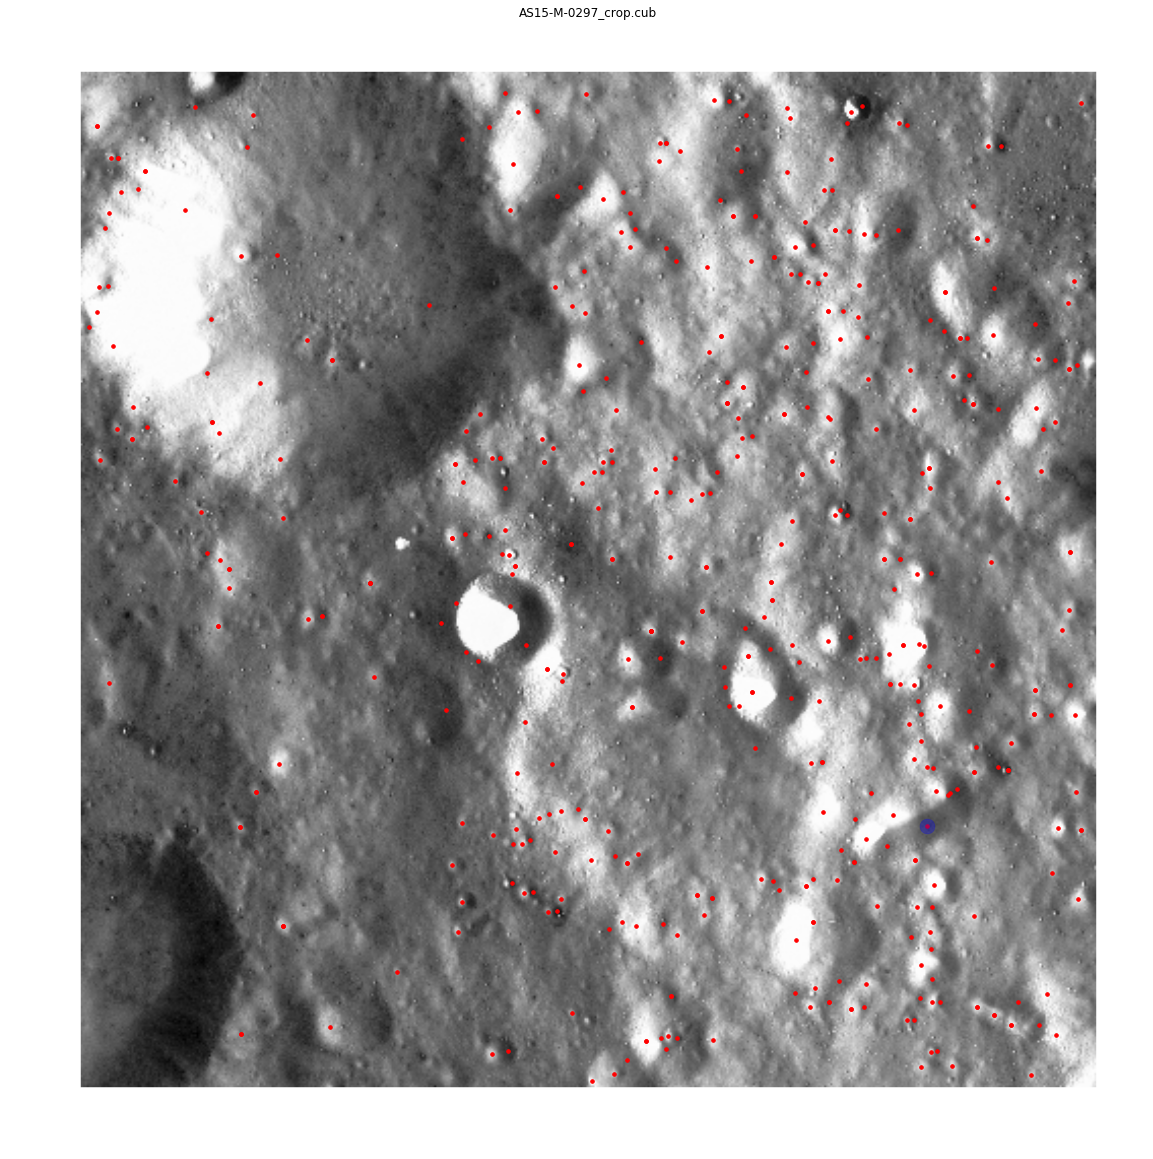

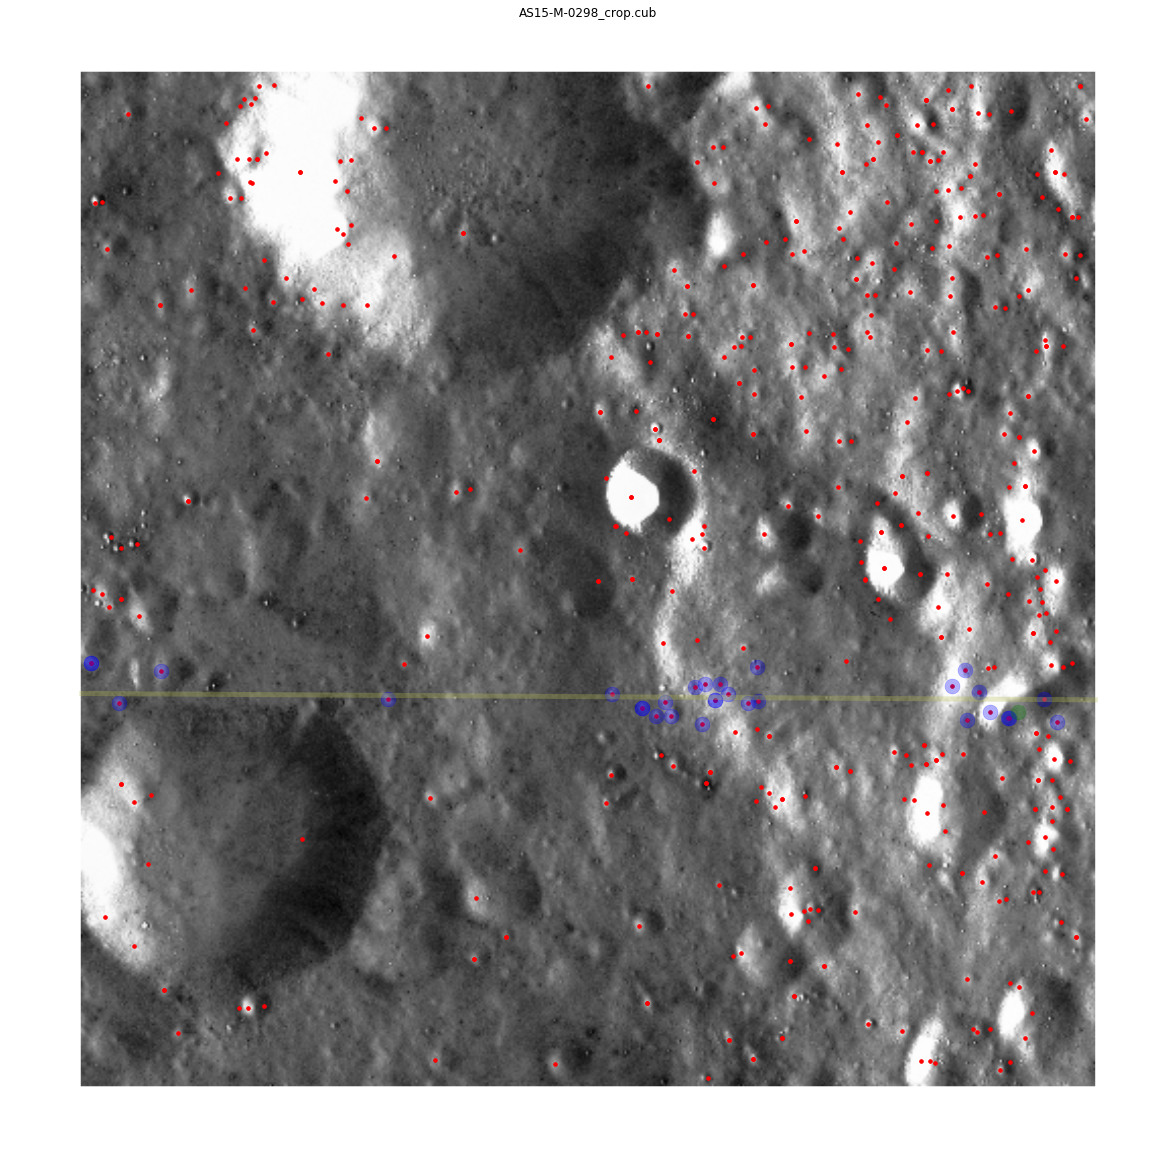

In [195]:
# For ploting a source < destination 
edge = cg.edge[0][1]
s_i = np.asarray([256])
d_i = e_line_correspondences[x]
# d_i = np.asarray([])
keypoint = edge.source.get_keypoint_coordinates(index = s_i, homogeneous = True).values
reproj_keypoint = source_to_dest(keypoint[0], edge.source, edge.destination)
f_matrix = edge['fundamental_matrix'].T
e_line = compute_epipolar_line(keypoint[0], f_matrix=f_matrix)
m=(-(e_line[0]/e_line[1]))
b=(-(e_line[2]/e_line[1]))
distance_list = {}

# kd_tree = KDTree(data = edge.destination.get_keypoint_coordinates(index = d_i, homogeneous=True))
# print(reproj_keypoint)
# nearest_neighbors = kd_tree.query(reproj_keypoint, 3)
# print(nearest_neighbors)
# d_i = d_i[1]
        
plt.figure(1)
edge.source.plot(clean_keys = 'fundamental', s = 50)
plot(edge.source.get_keypoint_coordinates().loc[s_i].x, edge.source.get_keypoint_coordinates().loc[s_i].y, 
     markersize = 30, marker = '.', alpha = .3, linewidth = 0)

plt.figure(2)
edge.destination.plot(clean_keys = 'fundamental', s = 50)
plot(edge.destination.get_keypoint_coordinates().loc[d_i].x, edge.destination.get_keypoint_coordinates().loc[d_i].y,
     markersize = 30, marker = '.', alpha = .3, linewidth = 0)
plot([0, 500], [get_y(0, m, b), get_y(500, m, b)], color = color, linewidth = 5, alpha = .3)
plot(reproj_keypoint[0], reproj_keypoint[1], 
     markersize = 30, marker = '.', alpha = .3, linewidth = 0)

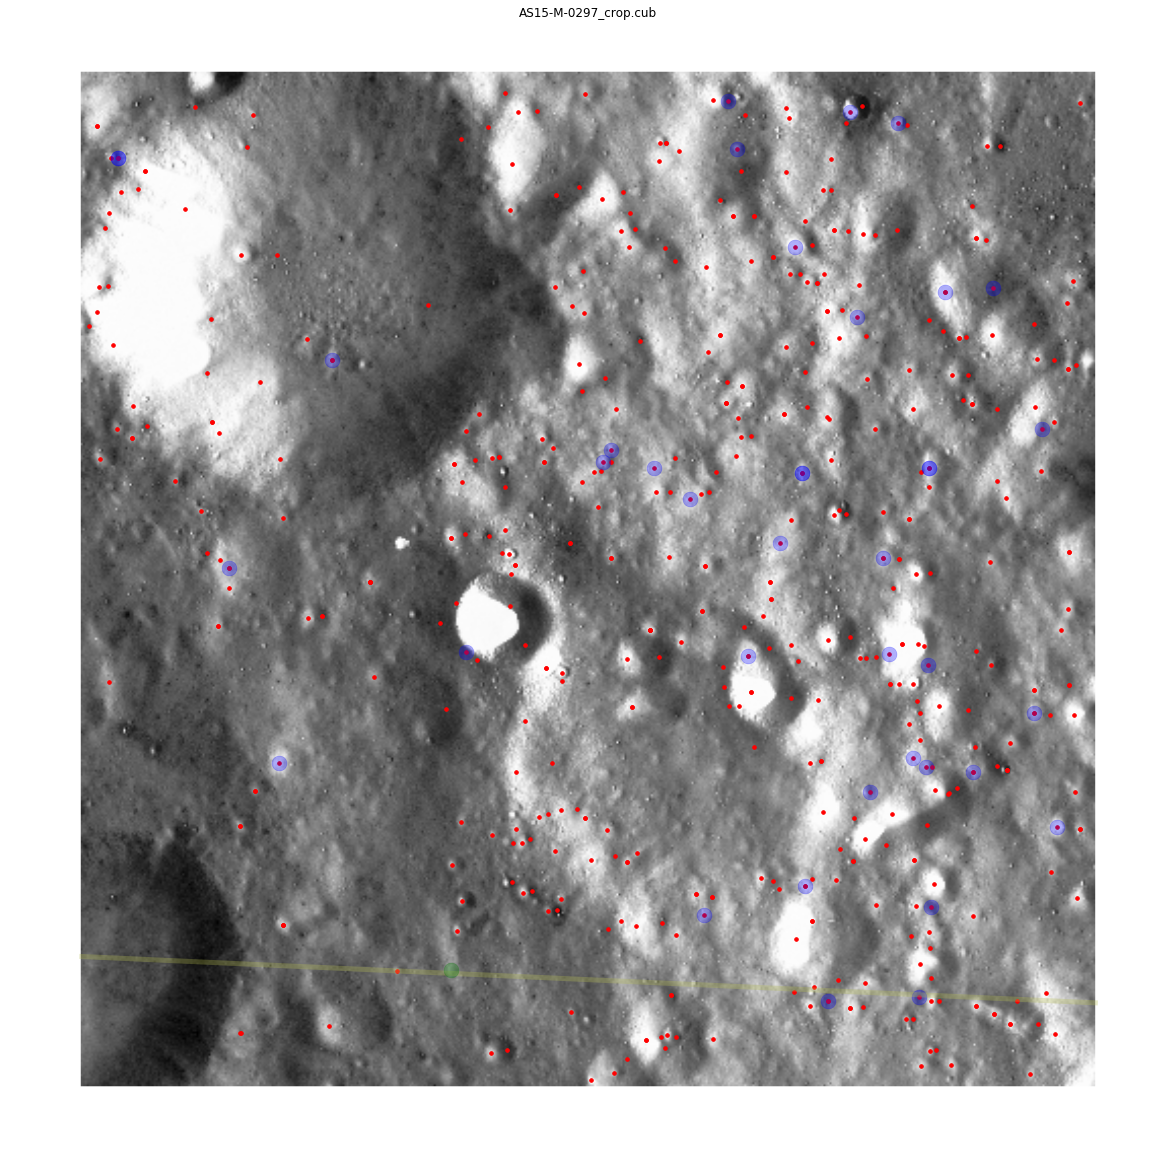

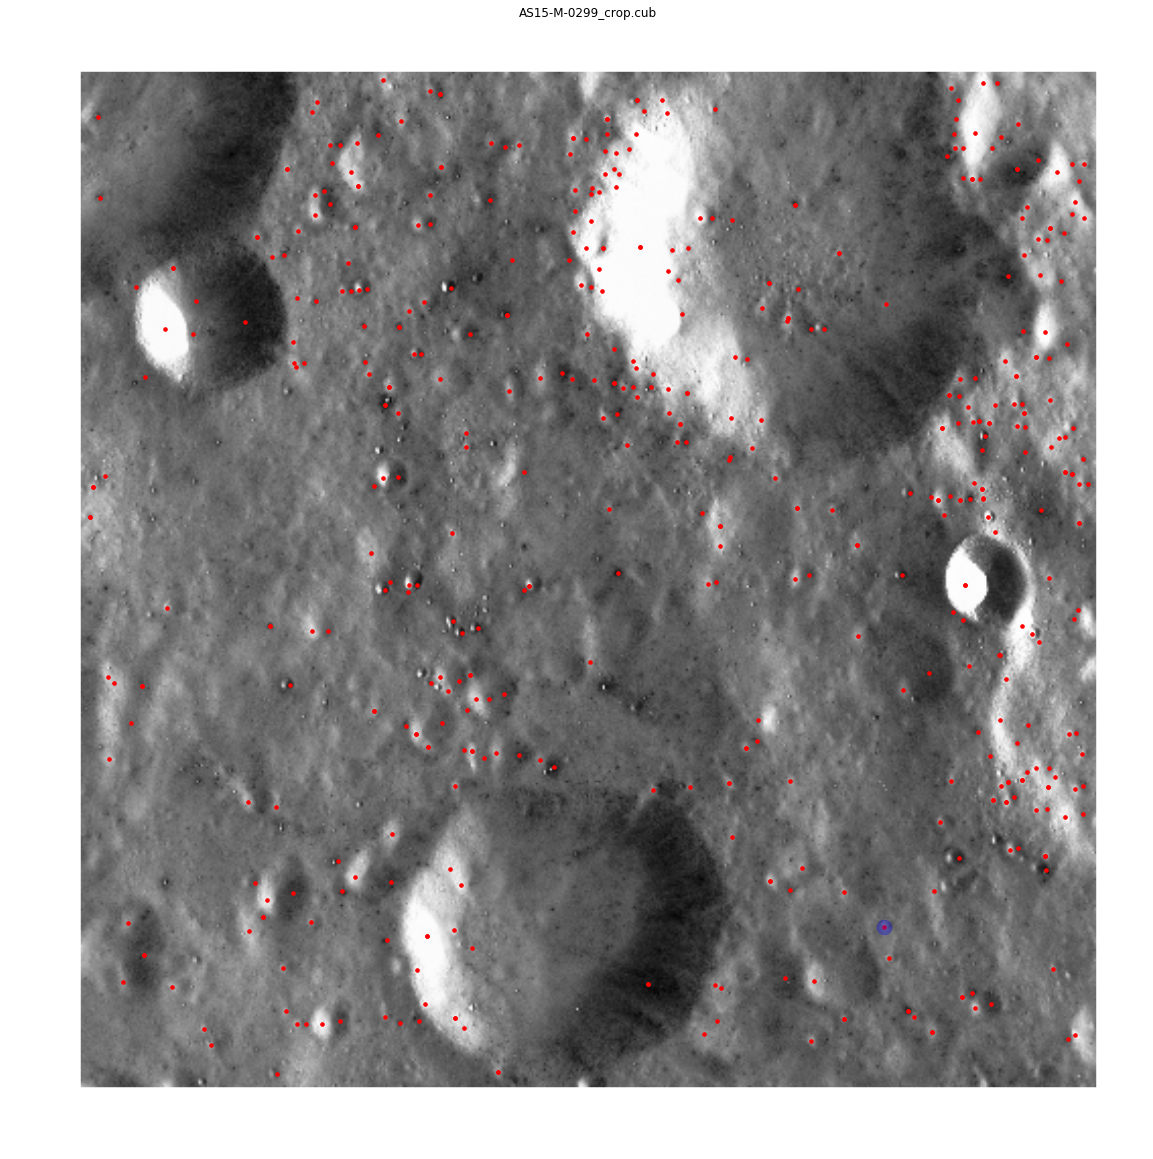

In [85]:
# For ploting a source > destination
edge = cg.edge[0][2]
s_i = e_line_correspondences[81]
# s_i = np.asarray([41, 319, 369, 449, 453])
d_i = np.asarray([355])
keypoint = edge.destination.get_keypoint_coordinates(index = d_i, homogeneous = True).values
reproj_keypoint = dest_to_source(keypoint[0], edge.source, edge.destination)
f_matrix = edge['fundamental_matrix']
e_line = compute_epipolar_line(keypoint[0], f_matrix=f_matrix)
m=(-(e_line[0]/e_line[1]))
b=(-(e_line[2]/e_line[1]))
distance_list = {}

# kd_tree = KDTree(data = edge.source.get_keypoint_coordinates(index = s_i, homogeneous=True))
# print(reproj_keypoint)
# nearest_neighbors = kd_tree.query(reproj_keypoint, 3)
# print(nearest_neighbors)
# s_i = s_i[1]
        
plt.figure(1)
edge.source.plot(clean_keys = 'fundamental', s = 50)
plot(edge.source.get_keypoint_coordinates().loc[s_i].x, edge.source.get_keypoint_coordinates().loc[s_i].y, 
     markersize = 30, marker = '.', alpha = .3, linewidth = 0)
plot([0, 500], [get_y(0, m, b), get_y(500, m, b)], color = color, linewidth = 5, alpha = .3)
plot(reproj_keypoint[0], reproj_keypoint[1], 
     markersize = 30, marker = '.', alpha = .3, linewidth = 0)

plt.figure(2)
edge.destination.plot(clean_keys = 'fundamental', s = 50)
plot(edge.destination.get_keypoint_coordinates().loc[d_i].x, 
     edge.destination.get_keypoint_coordinates().loc[d_i].y,
     markersize = 30, marker = '.', alpha = .3, linewidth = 0)

In [16]:
edge = cg.edge[0][2]
matches, mask = edge.clean(clean_keys = ['fundamental'])
# print(matches)
keypoints_list = []
e_keypoint_list = []
distance_list = []
m_list = []
b_list = []
for i in edge_dict[(0, 1)]:
    print(i)
    e_keypoint = cg.node[0].get_keypoint_coordinates(index = i, homogeneous = True).values
    e_keypoint_list.append(e_keypoint)

    f_matrix = edge['fundamental_matrix']
    
    e_line = compute_epipolar_line(e_keypoint, f_matrix=f_matrix)
    
    keypoints = cg.node[1].get_keypoint_coordinates(index = edge_dict[(0, 1)][i], homogeneous=True).values.T

    distance = np.abs(e_line.dot(keypoints))

    keypoints_list.append(keypoints)
    distance_list.append(distance)

    m_list.append(-(e_line[0]/e_line[1]))
    b_list.append(-(e_line[2]/e_line[1]))
    
plt.figure(1)
cg.node[1].plot(clean_keys = ['fundamental'])
j = 0
for i in keypoints_list:
    plt.figure(1)
    r = lambda: random.uniform(0.0, 1.0)
    color = [r(), r(), r()]
    plot(i[0], i[1], marker = '.', color = color, markersize = 25)
    plot([0, 500], [get_y(0, m_list[j], b_list[j]), get_y(500, m_list[j], b_list[j])], color = color, linewidth = 5)
    plt.figure(2)
    edge.plot_source(clean_keys = ['fundamental'])
    plot(e_keypoint_list[j][0], e_keypoint_list[j][1], color = color, markersize = 25, linewidth = 0, marker = '.')
    j += 1

NameError: name 'edge_dict' is not defined

In [ ]:
cg.compute_overlaps()
cg.overlap_checks()
matches, mask = cg.edge[0][1].clean(clean_keys = ['overlap'])
print(matches.head(20))
matches, mask = cg.edge[0][1].clean(clean_keys = ['fundamental'])
print(matches.head(10))

In [ ]:
edge = cg.edge[0][1]
kp = edge.destination.get_keypoint_coordinates(homogeneous=True).loc[8]
kps = edge.source.get_keypoint_coordinates(homogeneous = True).values
f_matrix = edge['fundamental_matrix'].T
index = add_point(kp, kps, dist_to_epipolar, compute_epipolar_line(f_matrix, kp), geometric_threshold = .2)
coords = kps[index]
print(coords)
# print(edge.source.get_keypoint_coordinates().loc[36])

In [ ]:
latlon_coords = edge.destination.geodata.pixel_to_latlon(edge.destination.get_keypoint_coordinates().loc[1].x,
                                                         edge.destination.get_keypoint_coordinates().loc[1].y)
print(edge.source.geodata.latlon_to_pixel(latlon_coords[0], latlon_coords[1]))
print(edge.source.get_keypoint_coordinates().loc[2])

In [ ]:
plt.figure(1)
edge.source.plot(clean_keys = 'fundamental', s = 50)
ax = plt.gca()
ax.scatter(coords.T[0], coords.T[1], s = 400, marker = '.', alpha = .5, color='b')
# plot(edge.source.get_keypoint_coordinates().loc[36].x, edge.source.get_keypoint_coordinates().loc[36].y)
plt.figure(2)
edge.destination.plot(clean_keys = 'fundamental', s = 50)
plot(edge.destination.get_keypoint_coordinates().loc[8].x, edge.destination.get_keypoint_coordinates().loc[8].y,
     markersize = 30, marker = '.', alpha = .5)

In [ ]:
# def deepen_correspondences(node, bc, keypoint_idx,
#                            clean_keys=[],
#                            geometric_threshold=2):

#     # Grab F for reprojection
#     f_matrix = bc['fundamental_matrix']

#     if f_matrix is None:
#         return None, None

#     # Compute the epipolar line projecting point ab into bc
#     ab_kp = node.get_keypoint_coordinates(homogeneous = True).loc[keypoint_idx]
#     epipolar_line = normalize_vector(ab_kp.dot(f_matrix.T))

#     # Check to see if a previously removed candidate fulfills the threshold geometric constraint
#     if node['node_id'] == edge.source['node_id']:
#         bc_candidates = bc.matches[(bc.matches['source_idx'] == keypoint_idx)]
#         bc_candidate_coords = bc.destination.get_keypoint_coordinates(index=bc_candidates['destination_idx'], 
#                                                                       homogeneous = True).values
# #         bc_candidate_coords = bc.destination.get_keypoint_coordinates(homogeneous = True).values
#     else:
#         bc_candidates = bc.matches[(bc.matches['destination_idx'] == keypoint_idx)]
#         bc_candidate_coords = bc.source.get_keypoint_coordinates(index=bc_candidates['source_idx'], 
#                                                                       homogeneous = True).values
# #         bc_candidate_coords = bc.source.get_keypoint_coordinates(homogeneous = True).values
    
#     bc_distance = np.abs(epipolar_line.dot(bc_candidate_coords.T))

#     # Get the matches
#     second_order_candidates = np.where(bc_distance < geometric_threshold)[0]

#     # In testing, every single valid second order candidate has a single, duplicated entry.
#     # That is, the correspondence has passed symmetry, but failed some other check.  Therefore,
#     # an additional descriptor distance check is omitted here.
#     if len(second_order_candidates) > 0:
#         coord_list = []
#         for i in second_order_candidates:
# #             new_match = bc_candidates.iloc[second_order_candidates[0]]
#             coord_list.append(bc_candidate_coords[i])
#         return coord_list
#     else:
#         return None, None